# First Steps With Julia
### Image Processing and Cleaning

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.utils.np_utils import to_categorical
from scipy.misc import imread
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
import glob
import string
%pylab inline

Using Theano backend.


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
## Converting the image to greyscale
def convert(im):
    grey = np.zeros((im.shape[0],im.shape[1]))
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            grey[i][j] = np.average(im[i][j])
    return grey

In [3]:
def get_letter(x):
    if x < 10:
        return x
    if x < 36:
        return list(lower.keys())[lower.values().index(x)]
    else:
        return list(upper.keys())[upper.values().index(x)]

In [4]:
## Getting the images from the directory to a numpy array
images = np.zeros((6283, 400))
for fname in sorted(glob.glob('/home/najeeb/Desktop/Dataset/Julia/trainResized/*.Bmp')):
    i = int(fname.split('/')[-1].strip('.Bmp'))
    im = convert(imread(fname))
    images[i-1] = im.reshape((400,))

In [5]:
X = np.asarray(images,dtype='float32')
print X.shape

(6283, 400)


In [39]:
## Bringing the training data
df = pd.read_csv('/home/najeeb/Desktop/Dataset/Julia/trainLabels.csv',index_col=0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6283 entries, 1 to 6283
Data columns (total 1 columns):
Class    6283 non-null object
dtypes: object(1)
memory usage: 98.2+ KB


,Class
ID,
1,n
2,8
3,T
4,I
5,R


In [40]:
lower = dict((w,i+10) for i,w in enumerate(string.ascii_lowercase))
upper = dict((w,i+10+len(lower)) for i,w in enumerate(string.ascii_uppercase))
def mapping(x):
    if str(x).isalpha():
        try:
            return lower[x]
        except:
            return upper[x]
    else:
        return int(x)

In [41]:
y = np.zeros((X.shape[0],),dtype = 'int32')
for i,val in enumerate(df['Class']):
    y[i] = mapping(val)

In [42]:
print y

[23  8 55 ..., 51 49 53]


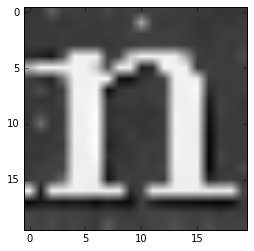

n
----------------------------------------


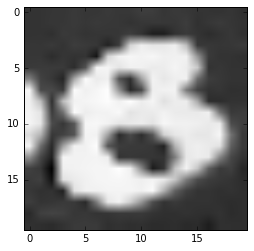

8
----------------------------------------


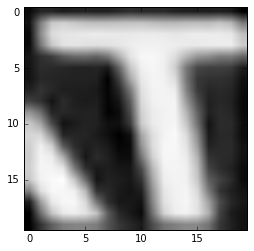

T
----------------------------------------


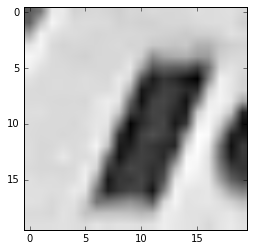

I
----------------------------------------


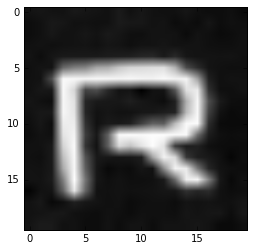

R
----------------------------------------


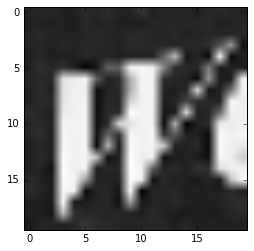

W
----------------------------------------


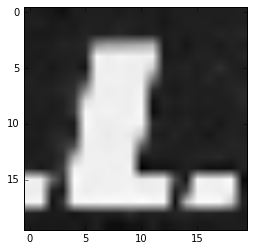

L
----------------------------------------


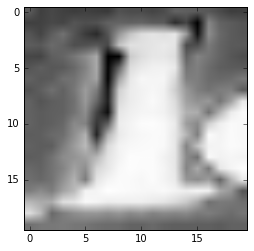

l
----------------------------------------


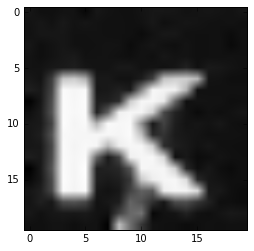

K
----------------------------------------


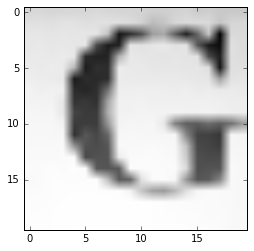

G
----------------------------------------


In [10]:
for i in range(10):
    plt.imshow(X[i,:].reshape((20,20)),cmap='Greys_r')
    plt.show()
    print get_letter(y[i])
    print '----------------------------------------'

In [43]:
nb_samples = X.shape[0]
threshold = int(0.75*nb_samples)
print nb_samples
X_train = X[0:threshold,:]
X_cv = X[threshold:,:]

6283


# A Simple Neural Network Model

In [12]:
y = to_categorical(y)

In [13]:
y_train = y[0:threshold,:]
y_cv = y[threshold:,:]

In [14]:
print X_train.shape,y_train.shape
print X_cv.shape,y_cv.shape

(4712, 400) (4712, 62)
(1571, 400) (1571, 62)


In [15]:
model = Sequential()
model.add(Dense(128,input_dim=400))
model.add(Activation('sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Activation('sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(62))
model.add(Activation('sigmoid'))

In [16]:
model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

In [17]:
model.load_weights('/home/najeeb/Desktop/Dataset/Julia/Weights.hdf5')

In [22]:
hist = model.fit(X_train,y_train,batch_size=128,nb_epoch=200,verbose=0)

In [23]:
model.save_weights('/home/najeeb/Desktop/Dataset/Julia/Weights.hdf5',overwrite=True)

In [24]:
score = model.evaluate(X_cv,y_cv,batch_size=32,verbose = 0)

In [25]:
print score

[2.2679294345012369, 0.46467218332272436]


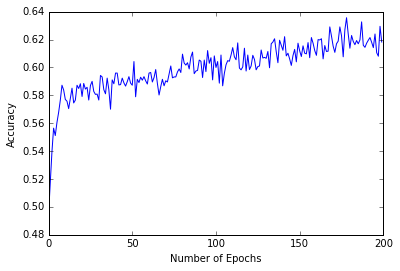

In [26]:
info = hist.history
plt.plot(info['acc'])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

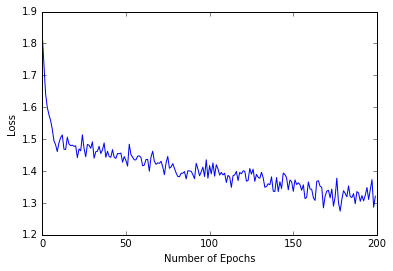

In [27]:
plt.plot(info['loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

## Random Forest Classifier

In [44]:
y_train = y[0:threshold]
y_cv = y[threshold:]

In [45]:
print X_train.shape,y_train.shape
print X_cv.shape,y_cv.shape

(4712, 400) (4712,)
(1571, 400) (1571,)


In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
forest = RandomForestClassifier(n_estimators = 1000,max_features=20,n_jobs = 2)

In [48]:
forest = forest.fit(X_train,y_train)

In [49]:
yPred = forest.predict(X_cv)

In [50]:
count = 0
for i in range(len(yPred)):
    if get_letter(yPred[i]) == get_letter(y_cv[i]):
        count += 1

In [51]:
print float(count)/len(yPred)

0.44812221515


## Using kNN Algorithm

In [55]:
from operator import itemgetter

In [56]:
y_train = y[0:threshold]
y_cv = y[threshold:]

In [57]:
print X_train.shape,y_train.shape
print X_cv.shape,y_cv.shape

(4712, 400) (4712,)
(1571, 400) (1571,)


In [58]:
X_train = X_train.T
X_cv = X_cv.T
print X_train.shape,X_cv.shape

(400, 4712) (400, 1571)


In [59]:
def euclidean(a,b):
        assert(type(a)) is numpy.ndarray
        assert(type(b)) is numpy.ndarray
        return np.dot(a-b,a-b)

In [60]:
def get_nearest_neighbors(X,i,k):
    ''' Returns the k nearest neighbours
        for the ith column vector. The 
        images are represented as matrix
        where each column represents an
        image. '''
    assert(type(X)) is numpy.ndarray
    nRows,nCols = X.shape
    if k > nCols:
        return 'Error: Number of nearest neigbours should be less than Columns of Parent Matrix'
    imageI = X[:,i]
    distance = np.zeros((nCols,))
    for j in range(nCols):
        imageJ = X[:,j]
        distance[j] = euclidean(imageI,imageJ)
    kNN = np.argsort(distance)[1:k+1]
    return kNN

In [61]:
def assign_labels(X,y,k,i):
    assert(type(X)) is numpy.ndarray
    count = {}
    highestCount = 0
    popularLabel = 0
    kNN = get_nearest_neighbors(X,i,k)
    for neighbour in kNN:
        label = y[neighbour]
        try:
            count[label] += 1
        except:
            count[label] = 1
    for label in count:
        if count[label] > highestCount:
            highestCount = count[label]
            popularLabel = label
    return popularLabel

In [63]:
k = 4
nRows,nCols = X_train.shape
yPred_kNN = [assign_labels(X_train,y_train,k,i) for i in range(nCols)]

In [64]:
count = 0
for i in range(len(yPred)):
    print "Predicted : "+str(get_letter(yPred[i]))
    print "Actual: "+str(get_letter(y_train[i]))
    print '---------------------------------------'
    if str(get_letter(yPred[i])) == str(get_letter(y_train[i])):
        count += 1

Predicted : n
Actual: n
---------------------------------------
Predicted : a
Actual: 8
---------------------------------------
Predicted : T
Actual: T
---------------------------------------
Predicted : T
Actual: I
---------------------------------------
Predicted : 0
Actual: R
---------------------------------------
Predicted : M
Actual: W
---------------------------------------
Predicted : L
Actual: L
---------------------------------------
Predicted : I
Actual: l
---------------------------------------
Predicted : E
Actual: K
---------------------------------------
Predicted : E
Actual: G
---------------------------------------
Predicted : I
Actual: A
---------------------------------------
Predicted : A
Actual: A
---------------------------------------
Predicted : E
Actual: C
---------------------------------------
Predicted : u
Actual: u
---------------------------------------
Predicted : I
Actual: t
---------------------------------------
Predicted : A
Actual: A
----------------

In [65]:
print float(count)*100/len(yPred)

34.80475382


## Getting Test data

In [28]:
test = np.zeros((6220, 400))
for fname in sorted(glob.glob('/home/najeeb/Desktop/Dataset/Julia/testResized/*.Bmp')):
    i = int(fname.split('/')[-1].strip('.Bmp'))
    im = convert(imread(fname))
    test[i-6284] = im.reshape((400,))

In [29]:
X_test = np.asarray(test,dtype='float32')
print X_test.shape

(6220, 400)


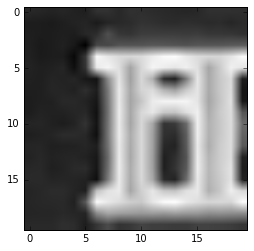

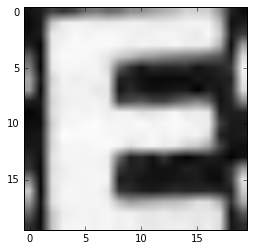

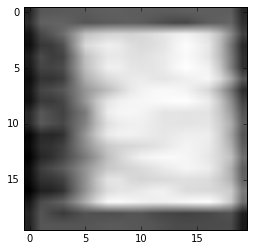

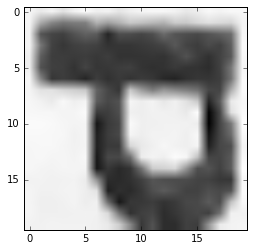

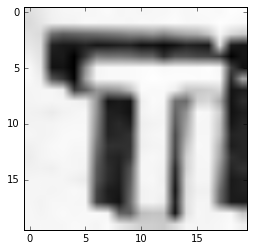

In [31]:
for i in range(5):
    plt.imshow(X_test[i,:].reshape((20,20)),cmap='Greys_r')
    plt.show()

### Running on Neural Network

In [35]:
yPred = model.predict_classes(X_test,batch_size = 32,verbose=1)

6220/6220 [==============================] - 1s     


In [38]:
import csv
with open("submission.csv","wb") as fp:
    p = csv.writer(fp)
    p.writerow(["ID","Class"])
    for i in range(len(yPred)):
        p.writerow([i+6284,get_letter(yPred[i])])

Got 45.746 percent accuracy on Kaggle Submission

### Running on Random Forests

In [52]:
yPred_forest = forest.predict(X_test)

In [54]:
with open("submission_forest.csv","wb") as fp:
    p = csv.writer(fp)
    p.writerow(["ID","Class"])
    for i in range(len(yPred_forest)):
        p.writerow([i+6284,get_letter(yPred_forest[i])])

Got 44.928 percent accuracy on Kaggle Submission